<a href="https://colab.research.google.com/github/yucellgereklioglu/datasciencework/blob/main/German_Credit_risk_with_meta_stacking_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/german_credit_data.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [ ]:
le=LabelEncoder()
df['Sex']=le.fit_transform(df['Sex'])
df['Housing']=le.fit_transform(df['Housing'])
df['Saving accounts']=le.fit_transform(df['Saving accounts'])
df['Checking account']=le.fit_transform(df['Checking account'])
df['Purpose']=le.fit_transform(df['Purpose'])

In [ ]:
df.fillna(df.median(),inplace=True)

In [ ]:
df['Credit amount'].mean()

np.float64(3271.258)

In [ ]:
df['Credit_risk_label'] = df['Credit amount'].apply(lambda x: 'Low Risk' if x <= 3270 else 'High Risk')
df['Credit_risk_label']=le.fit_transform(df['Credit_risk_label'])
df['Credit_risk_label']


,Credit_risk_label
0,1
1,0
2,1
3,0
4,0
...,...
995,1
996,0
997,1
998,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [ ]:
y=df['Credit_risk_label']
x=df.drop(['Credit_risk_label','Credit amount'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
params_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 2]
}
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}


In [ ]:
random_rf=RandomizedSearchCV(estimator=RandomForestClassifier(),param_distributions=params_rf,cv=3,verbose=2,n_jobs=-1)
random_rf.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   verbose=2)

In [ ]:
random_xgb=RandomizedSearchCV(estimator=XGBClassifier(),param_distributions=params_xgb,cv=3,verbose=2,n_jobs=-1)
random_xgb.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 1],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200],
                                        'reg_alpha': [0, 0.5],
                                        'reg_lambda': [1, 2],
                                        'subsample': [0.8, 1.0]},
                   verbose=2)

In [ ]:
best_rf=random_rf.best_params_
bestmodelrf=RandomForestClassifier(**best_rf)
bestmodelrf.fit(x_train,y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200)

In [ ]:
best_xgb=random_xgb.best_params_
bestmodelxgb=XGBClassifier(**best_xgb)
bestmodelxgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_rf=bestmodelrf.predict(x_test)
y_pred_xgb=bestmodelxgb.predict(x_test)

In [ ]:
meta_features=np.column_stack((y_pred_rf,y_pred_xgb))
meta_model=LogisticRegression()
meta_model.fit(meta_features,y_test)

LogisticRegression()

In [ ]:
y_pred_meta=meta_model.predict(meta_features)
accuracy_score(y_pred_meta,y_test)

0.77

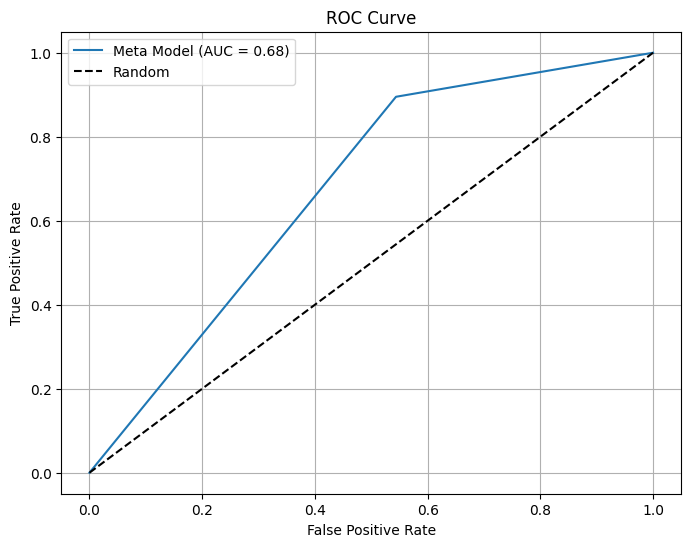

Accuracy of the Meta Model: 0.77


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred_meta)
auc = roc_auc_score(y_test, y_pred_meta)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Meta Model (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
accuracy = accuracy_score(y_test, y_pred_meta)
print(f'Accuracy of the Meta Model: {accuracy:.2f}')

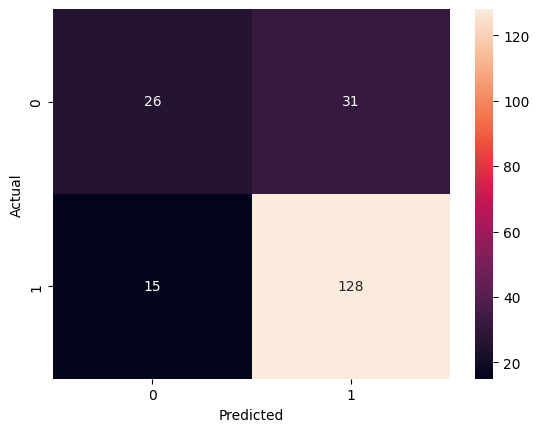

In [ ]:
cm=confusion_matrix(y_test,y_pred_meta)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()